# Exploratory Data Analysis of the Waymo Open Dataset

## Scene Attributes

This Jupyter Notebook explores Scene Data extracted from the labels of approximately 8,000 frames of the Waymo Open Dataset. 


In [139]:
import os
import tensorflow as tf
import math
import numpy as np
import pandas as pd
import itertools
import collections
from scipy import stats
import eda_stats as es
from tabulate import tabulate

In [4]:
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [5]:
frames_df = pd.read_csv('frames8k.csv')

In [6]:
frames_df = frames_df.drop(['unknown_count'],axis=1)

In [67]:
frames_df['all_object_count'] = frames_df['pedestrian_count'] + frames_df['cyclist_count'] + frames_df['vehicle_count']
count_columns = ['cyclist_count', 'pedestrian_count', 'sign_count', 'vehicle_count']

33.0 234.0
27.0 163.0
0.32597644141351517 0.0 11.0


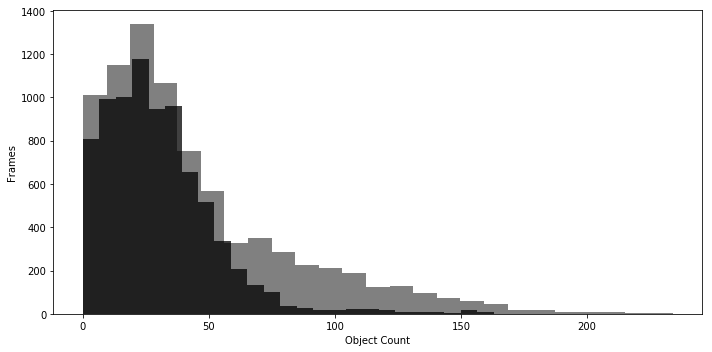

In [74]:
frames_df['all_object_count'].hist(bins=25, grid=False, figsize=(10,5), color='grey')
frames_df['vehicle_count'].hist(bins=25, grid=False, figsize=(10,5), alpha=0.75, color='black')
plt.xlabel('Object Count')
plt.ylabel('Frames')
plt.tight_layout()

print(frames_df['all_object_count'].median(), frames_df['all_object_count'].max())
print(frames_df['vehicle_count'].median(), frames_df['vehicle_count'].max())
print(frames_df['cyclist_count'].mean(), frames_df['cyclist_count'].median(), frames_df['cyclist_count'].max())

In [ ]:
def plot_subgroup_hist(df, columns, labels=("Pedestrian", "Vehicle")):
    
    fig, axs = plt.subplots(2,2, figsize=(10, 5))
    for col_name, ax in zip(df.columns, axs.flatten()):
        bins = np.linspace(df[col_name].min(), df[col_name].max(), 30)
        height, binz = np.histogram(sub_a[col_name], bins=bins, density=True)
        bp1 = ax.bar(bins[:-1], height, .5*(bins[1]-bins[0]),
                     alpha=0.5, label=sub_a, color='g')
        height, binz = np.histogram(sub_b[col_name], bins=bins, density=True)
        bp2 = ax.bar(bins[:-1]+.5*(bins[1]-bins[0]), height,
                     .5*(bins[1]-bins[0]), color='b', alpha=.5)
        ax.set_title(str(col_name).split('_', 1)[-1].title())
        ax.legend((bp1[0], bp2[0]), labels, loc='best')

    plt.tight_layout()

    return fig, ax

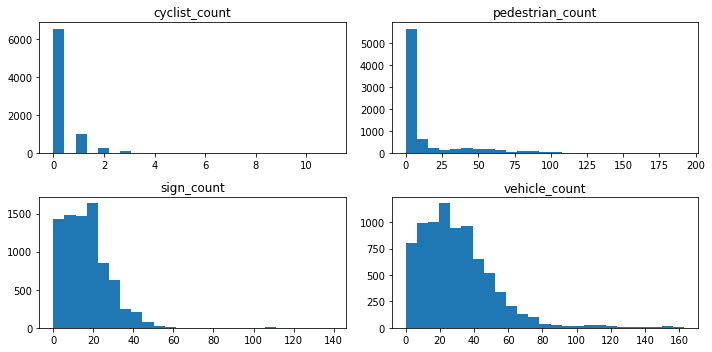

In [138]:
frames_df[count_columns].hist(bins=25, grid=False, figsize=(10,5))
plt.tight_layout()
plt.savefig('object_dist.png',bbox_inches='tight');

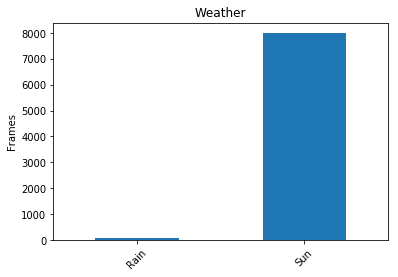

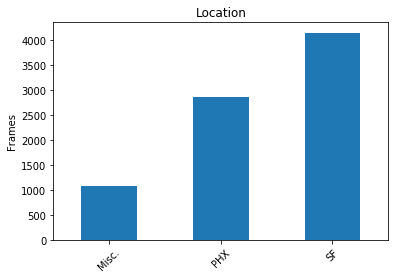

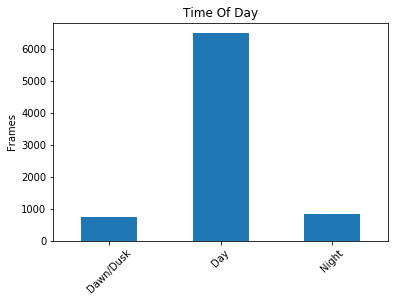

In [142]:
def plot_bar_counts(df, group_column, count_column, labels):
    counts = df.groupby(group_column).count()

    count_column_title = count_column.replace('_', ' ').title()
    group_column_title = group_column.replace('_', ' ').title()

    fig, ax = plt.subplots()
    counts[count_column].plot(kind='bar')
    plt.title(group_column_title)
    plt.xlabel('')
    plt.ylabel('Frames')
    ax.set_xticklabels(labels, rotation=45)
    plt.show;

plot_bar_counts(frames_df, 'weather', 'Unnamed: 0', ['Rain', 'Sun'])
#plt.savefig('weather.png',bbox_inches='tight')
plot_bar_counts(frames_df, 'location', 'Unnamed: 0',['Misc.', 'PHX', 'SF'])
#plt.savefig('location',bbox_inches='tight');
plot_bar_counts(frames_df, 'time_of_day', 'Unnamed: 0', ['Dawn/Dusk', 'Day', 'Night'])
#plt.savefig('time.png',bbox_inches='tight');

We can see from the plots above that there are really very few rainy-day scenes. Let's see how many there really are:

In [14]:
print('Total number of rainy days: {}'.format(frames_df[frames_df['weather'] == 'rain'].shape[0]))

Total number of rainy days: 67


Now let's see if there's any real difference in object instance counts based on the scene attributes of Location, Time of Day, and Weather.

Below, we've computed the mean of the object instance counts by class for each scene attribute.

In [15]:
frames_df.groupby('location').mean().round()[count_columns]

,cyclist_count,pedestrian_count,sign_count,vehicle_count
location,,,,
location_other,0.0,3.0,18.0,30.0
location_phx,0.0,2.0,12.0,23.0
location_sf,0.0,25.0,19.0,36.0


In [16]:
frames_df.groupby('time_of_day').mean().round()[count_columns]

,cyclist_count,pedestrian_count,sign_count,vehicle_count
time_of_day,,,,
Dawn/Dusk,0.0,5.0,13.0,27.0
Day,0.0,16.0,17.0,31.0
Night,0.0,8.0,16.0,27.0


In [17]:
frames_df.groupby('weather').mean().round()[count_columns]

,cyclist_count,pedestrian_count,sign_count,vehicle_count
weather,,,,
rain,0.0,0.0,5.0,19.0
sunny,0.0,14.0,17.0,31.0


Of course, our sample of rainy-day scenes is too small to draw any conclusions. However, it appears that Time of Day and Location may have some affect on our object instance counts.

In the tables above, it appears that there are far more Pedestrians on average in San Francisco than anywhere else. Pedestrian counts also seem to be slightly higher on average during the day. It also seems that San Francisco may have slightly more Vehicle objects on average.

Unfortunately, because the Cyclist object instance is so limited in our sample, we can't draw any conclusions about this class.

Since we noticed a difference in the average Vehicle count between SF and PHX, lets plot the histogram of the Vehicle object counts for each city on the same axis:

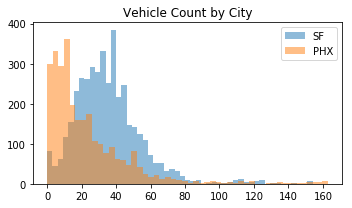

In [153]:
phx_frames = frames_df[frames_df['location'] == 'location_phx']
sf_frames = frames_df[frames_df['location'] == 'location_sf']

veh_bins = 50

sf_frames['vehicle_count'].hist(bins=veh_bins, figsize=(5, 3), grid=False, alpha=0.5)
phx_frames['vehicle_count'].hist(bins=veh_bins, figsize=(5, 3), grid=False, alpha=0.5)
plt.title('Vehicle Count by City')
plt.legend(('SF', 'PHX'), loc='best')
plt.tight_layout()

Now let's look at the histogram of Pedestrian counts for the two cities. We're going to remove any of the frames with zero Pedestrian objects before we plot, or the histogram will be too hard to really see.

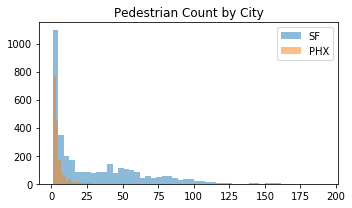

In [164]:
phx_frames_not_zero = phx_frames[phx_frames['pedestrian_count']>0]
sf_frames_not_zero = sf_frames[sf_frames['pedestrian_count']>0]

sf_frames_not_zero['pedestrian_count'].hist(bins=veh_bins, figsize=(5, 3), grid=False, alpha=0.5)
phx_frames_not_zero['pedestrian_count'].hist(bins=veh_bins, figsize=(5, 3), grid=False, alpha=0.5)
plt.title('Pedestrian Count by City')
plt.legend(('SF', 'PHX'), loc='best')
plt.tight_layout()

The histograms appear to reinforce what we saw in the tables above. Let's perform a U-Test on these object counts so we can draw a conclusion based on the p-value.

In [167]:
pvalue_count = es.utest(phx_frames, sf_frames, 'vehicle_count')
print('Vehicle Count by City: ' + str(pvalue_count.round(7)))

Vehicle Count by City: 3.8e-06


In [168]:
pvalue_count = es.utest(phx_frames, sf_frames, 'pedestrian_count')
print('Pedestrian Count by City: ' + str(pvalue_count.round(9)))

Pedestrian Count by City: 4.3e-08


These p-values are so small! Let's see the result of the U-Test for Vehicle counts between "Night" and "Day." Based on the tables above, there seems to be only a small difference between Vehicle counts at different times of day, and that could just be noise.


In [171]:
day_frames = frames_df[frames_df['time_of_day'] == 'Day']
night_frames = frames_df[frames_df['time_of_day'] == 'Night']

In [191]:
pvalue_count = es.utest(day_frames, night_frames, 'vehicle_count')
print('Vehicle Count by Time: ' + str(pvalue_count.round(7)))

Vehicle Count by Time: 0.1317998


Based on this p-value, we can't draw any conclusions about Vehicle counts given time of day. Let's see what the histogram looks like.

We'll take a 1,000-frame sample from the Day scenes to even out the disparity in the total number of Day versus Night scenes.

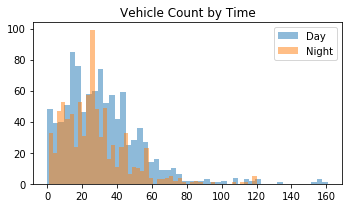

In [192]:
day_frames['vehicle_count'].sample(1000).hist(bins=veh_bins, figsize=(5, 3), grid=False, alpha=0.5)
night_frames['vehicle_count'].hist(bins=veh_bins, figsize=(5, 3), grid=False, alpha=0.5)
plt.title('Vehicle Count by Time')
plt.legend(('Day', 'Night'), loc='best')
plt.tight_layout()

Considering our p-value, this histogram should look just like we expected: there is really no discernable difference between Vehicle object counts in the Daytime versus Nighttime.